<a href="https://colab.research.google.com/github/vaipatel/JaxNeuralODEs/blob/master/Jax_NeuralODEs_LambdaSpiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing a Neural ODE's experiment in Jax

This notebook is my attempt to reproduce the [ode_demo.py](https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py) experiment from `torchdiffeq` using [Jax](https://github.com/google/jax).

![](https://github.com/vaipatel/JaxNeuralODEs/blob/master/LambdaSpiral_output.gif?raw=true)

## Imports

Let's import `matplotlib`, `numpy` and of course, `jax`. We'll primarily be using `jax` for all of our calculations, including 
* creating our experiment data
* defining our dynamics
* performing the forward ODE solve
* finding the loss gradient with jax's built-in reverse Adjoint ODE solve, and
* optimizing the parameters using gradient descent

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as onp

!pip install jaxlib==0.1.45
!pip install jax==0.1.64
from jax.experimental.ode import odeint
from jax import jit, grad, value_and_grad, vmap, random
import jax.numpy as np
from jax.tree_util import tree_unflatten#, tree_flatten
from jax.flatten_util import ravel_pytree
from jax.experimental.optimizers import adam, rmsprop
np.set_printoptions(suppress=True)

## Experiment Args

Let's create a generic Args class so we can pretend that the args came from a command line argument parser.

In [0]:
class Args:
  def __init__(self, data_size=1000, batch_size=20, batch_time=10, n_iters=2000,
               test_freq=20, dt=0.025, step_size=0.009, viz=True,
               should_close_fig=True):
    self.data_size = data_size # overall training data size
    self.batch_size = batch_size # size of batch of initial states
    self.batch_time = batch_time # num timepoints into the future in a batch of initial states
    self.n_iters = n_iters # num epochs
    self.test_freq = test_freq # freq at which should test the model
    self.dt = dt # odeint desired step size. Not used.
    self.step_size = step_size # optimizer step size
    self.viz = viz # flag to tell if should create picture

## Experiment Description and Setup

Our experiment data is going to consist of points calculated by forward solving the following non-linear ODE

$$ \frac{\mathrm{d}y}{\mathrm{d}t} = h(y(t),t) =
\begin{bmatrix}
-0.1 & 2.0\\
−2.0 & −0.1
\end{bmatrix} y^3 $$

with initial condition

$$ y(t_0) = \begin{bmatrix} 2 & 0 \end{bmatrix} $$

Our goal will then be to recover the true dynamics $h(y,t)$ as best we can, from only the dataset of points along the trajectory emanating from $y(t_0)$.

### Dataset generation and viz helpers

In [0]:
def create_true_params():
  true_y0 = np.array([2., 0.])
  true_A = np.array([[-0.1, 2.0],
                    [-2.0, -0.1]])
  return true_y0, true_A

def LambdaFunc(y, t, true_A):
  return np.matmul(y**3, true_A)

def create_training_data(args):
  ts = np.linspace(0., 25., num=args.data_size)
  true_y0, true_A = create_true_params()
  true_y = odeint(LambdaFunc, true_y0, ts, true_A)
  return ts, true_y0, true_y

In [0]:
def get_fig_and_axes():
  fig = plt.figure(figsize=(18, 6), facecolor='white')
  ax_traj = fig.add_subplot(131, frameon=False)
  ax_phase = fig.add_subplot(132, frameon=False)
  ax_vecfield = fig.add_subplot(133, frameon=False)
  return fig, ax_traj, ax_phase, ax_vecfield

def viz_experiment_data(experiment_data, odefunc=None, pred_y=None, plot_name=None,
                        should_close_fig=True):
  ts, true_y0, true_y = experiment_data
  true_y = true_y.reshape((-1,1,2))
  if pred_y is not None:
    pred_y = pred_y.reshape((-1,1,2))
  fig, ax_traj, ax_phase, ax_vecfield = get_fig_and_axes()
  # plt.show(block=False)

  ax_traj.cla()
  ax_traj.set_title('Trajectories')
  ax_traj.set_xlabel('t')
  ax_traj.set_ylabel('x,y')
  ax_traj.plot(ts, true_y[:, 0, 0], 'g-', label="True x")
  ax_traj.plot(ts, true_y[:, 0, 1], 'b-', label="True y")
  if pred_y is not None:
    ax_traj.plot(ts, pred_y[:, 0, 0], 'g--', label="Pred x")
    ax_traj.plot(ts, pred_y[:, 0, 1], 'b--', label="Pred y")
  ax_traj.set_xlim(ts.min(), 1.05*ts.max())
  ax_traj.set_ylim(-2, 2)
  ax_traj.legend()

  ax_phase.cla()
  ax_phase.set_title('Phase Portrait')
  ax_phase.set_xlabel('x')
  ax_phase.set_ylabel('y')
  ax_phase.plot(true_y[:, 0, 0], true_y[:, 0, 1], 'g-', label='True x,y')
  if pred_y is not None:
    ax_phase.plot(pred_y[:, 0, 0], pred_y[:, 0, 1], 'b-', label='Pred x,y')
  ax_phase.set_xlim(-2, 2)
  ax_phase.set_ylim(-2, 2)
  ax_phase.legend()

  ax_vecfield.cla()
  ax_vecfield.set_title('Learned Vector Field')
  ax_vecfield.set_xlabel('x')
  ax_vecfield.set_ylabel('y')

  y, x = onp.mgrid[-2:2:21j, -2:2:21j]
  dydt = odefunc(y=np.stack([x, y], -1).reshape(21 * 21, 2))
  mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
  dydt = (dydt / mag)
  dydt = dydt.reshape(21, 21, 2)

  ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
  ax_vecfield.set_xlim(-2, 2)
  ax_vecfield.set_ylim(-2, 2)

  fig.tight_layout()
  
  if plot_name is not None:
    plt.savefig("pngs/"+plot_name)

  if should_close_fig:
    plt.close(fig)
    del fig

def create_and_viz_training_data(experiment_args):
  !rm -rf pngs
  !mkdir pngs
  experiment_data = create_training_data(experiment_args)
  true_y0, true_A = create_true_params()
  odefunc = lambda y: LambdaFunc(y, experiment_data[0], true_A)
  viz_experiment_data(experiment_data, odefunc=odefunc,
                      plot_name="experiment_data.png", should_close_fig=False)
  return experiment_data

### Generate and viz the experiment data

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


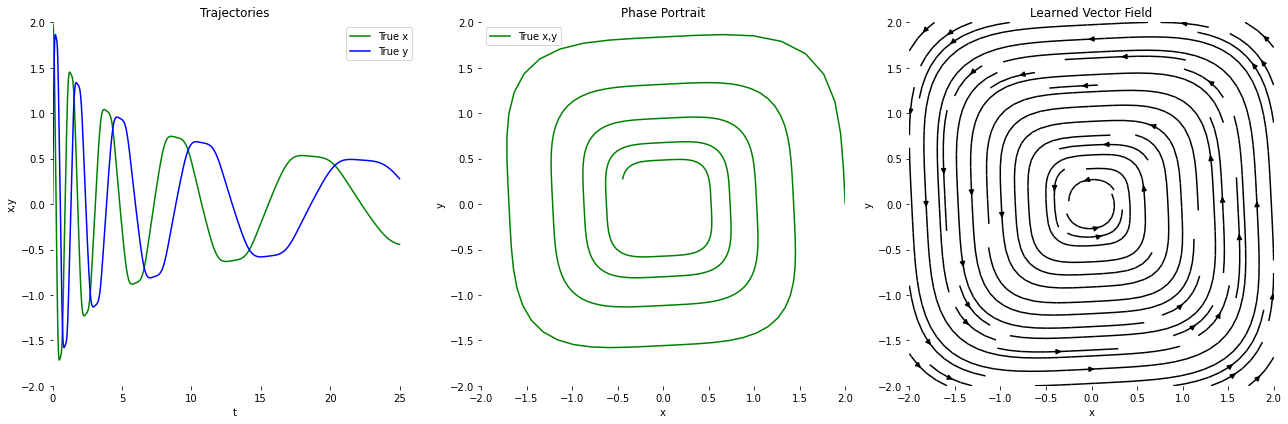

In [0]:
experiment_args = \
  Args(data_size=1000, batch_size=20, batch_time=10, n_iters=2000,
       test_freq=20, step_size=5e-4, viz=True)

experiment_data = create_and_viz_training_data(experiment_args)

## Understanding Neural ODEs

So how do Neural ODEs help us? Well, Neural ODEs use a constrained optimization approach using inspiration from modern deep learning:
* Believe that our true dynamics function $h(y, t)$ can be captured by a neural network $f(y, t, \theta)$, parameterized by $\theta$.
* Define some loss $L(y(t_0),\hat{y}(t_0), y(t_1), \hat{y}(t_1), .., y(t_{T-1}), \hat{y}(t_{T-1}))$ that captures the discrepancy between some points $y(t_0), .., y(t_{T-1})$ along the true dynamics trajectory and corresponding points $\hat{y}(t_0), .., \hat{y}(t_{T-1})$ along the approximated trajectory.
* Look for $\theta$ that are a local minimum of $L$ using gradient descent.

In the forward pass, we use some ODE solver to get from inputs to predictions and then calculate $L$.

For the backward pass, we will first need to calculate the gradient of the loss $L$ with respect to $\theta$, or $\frac{\mathrm{d}L}{\mathrm{d}\theta}$.

Now, the ODE solver might have taken a huge number of steps in the forward solve. This could happen because, say, an adaptive solver encountered very high errors in some region and decided to significantly shrink its step size thus leading to a huge number of steps. Think of the ODE solver's computation graph as potentially becoming a very very deep neural network.

The problem here is that as our network grows, so to do our memory requirements for using backpropagation to calculate $\frac{\mathrm{d}L}{\mathrm{d}\theta}$. Why? Because backprop requires us to store all the values at every layer from the forward pass.

To circumvent the memory requirements of backprop, Neural ODEs leverage a technique well known in the Optimal Control literature called "Adjoint Sensitivity Analysis". The technique trades off memory for computation and proceeds by first solving another ODE backward in time starting at the final time $t_{T-1}$ and ending at $t_0$.

$$ \frac{\mathrm{d}a(t)}{\mathrm{d}t} = -a(t)\frac{\partial{f}}{\partial{y}}, \\ \text{s.t.} \quad a(t_i) = \frac{\partial{L}}{\partial{y(t_i)}} \\ \text{giving} \quad a(t_{i-1}) = a(t_i) - \int_{t_{i}}^{t_{i-1}}a(t)\frac{\partial{f}}{\partial{y}}$$

The quantity $a(t)$ is called the adjoint, and with it we can calculate the promised loss gradient with yet another reverse ODE solve as follows.

$$ \frac{\mathrm{d}L}{\mathrm{d}\theta} = -\int_{t_{T-1}}^{t_0}a(t)\frac{\partial{f}}{\partial{\theta}} $$

The quantity $a(t)$ and the above ODEs seem like they pop out of nowhere, but the proofs are not so hard to follow. The traditional proof leverages the theory of Lagrange Multipliers, and the authors of the Neural ODEs paper present a modern alternative to boot.

### Why Jax?

Notice the two products above.

$$ a(t)\frac{\partial{f}}{\partial{y}} \quad \text{and} \quad a(t)\frac{\partial{f}}{\partial{\theta}}  $$

$a(t)$ is a row vector while $\frac{\partial{f}}{\partial{y}}$ and $\frac{\partial{f}}{\partial{\theta}}$ are Jacobian matrices.

These products are called vector-Jacobian products or vJps.

The cool thing about Jax (and autograd, PyTorch etc.) is that it has a very simple APIs for efficiently calculating vJps. Efficiency here means that the Jacobian matrices, which can be very large, are never fully instantiated in memory. Instead, Jax knows the simplified expressions of the product of a row vector with the Jacobians with respect to inputs/params for nearly all common functions. Jax also knows how to compose those products together for complicated compositions of common functions.

In the end, the cost of calculating a vJp like $a(t)\frac{\partial{f}}{\partial{y}}$ is quite comparable to the cost of calculating the original function $f(y)$.

Actually, the authors/contributors of Jax have already leveraged Jax's awesome vJp capabilities and added a differentiable ODE solver, where the gradient with respect to the parameters is calculated using precisely the Adjoint method described above!

So with Jax, we can calculate the forward pass, loss and loss gradient for Neural ODEs in almost a single line of code!

Let's get started!

## Define dynamics

### Neural net params maker

Let's first make a helper to create and randomly initialize our neural network params, keeping in mind that the network has fully-connected layers and that the input and output shapes are to be the same.

An alternative to writing our own params-making would be to use `jax.experimental.stax`, Jax's neural-net building library. But our neural net is fairly simple, so we will eschew using `stax` for now.

In [0]:
def make_net_params(state_dims=2, hidden_layer_dims=[50], scale=0.1):
  """Makes a neural net with in-shape and out-shape (state_dims,) and with
     params-shape (state_dims, hidden_layer_dims[:], state_dims).
  """
  def random_layer_params(m, n, key, scale=scale):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), \
           scale * random.normal(b_key, (n,))

  def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k\
            in zip(sizes[:-1], sizes[1:], keys)]
  layer_sizes = [state_dims, *hidden_layer_dims, state_dims]
  params = init_network_params(layer_sizes, random.PRNGKey(0))
  return params

### Use Neural Net as Dynamics Approximator

As we seen, we'll approximate our `dynamics` function $f(y, t, \theta)$ with a neural net.

Specifically, we'll use a simple neural net that has fully-connected layers and uses $\tanh(x)$ non-linearity for the hidden layers.

In [0]:
def dynamics(y, t, params):
  """The RHS of our ODE dy/dt. For eg., for 1 hidden layer in params we get
     dy/dt = W2*tanh(W1*(y^3) + b1) + b2
     Note: Don't pass a batch for y to dynamics.
  """
  # Our dynamics does not have an explicit dependence on t.
  activations = np.power(y, 3)
  for w, b in params[:-1]:
    outputs = np.dot(w, activations) + b
    activations = np.tanh(outputs)
  
  final_w, final_b = params[-1]
  output = np.dot(final_w, activations) + final_b
  return output

#: Make a batched version of the `dynamics` function
#: Below in Jax's `vmap`, `in_axes` is saying that we want to
#: * batch over the first dimension of the second arg in dynamics, which is y
#: * not batch over the first and third args in dynamics, which are time, params
batched_dynamics = jit(vmap(dynamics, in_axes=(0, None, None)))

### Define forward pass helpers

In [0]:
def forward(y0, t, p):
  return odeint(batched_dynamics, y0, t, p)

def forward_and_loss(y0, t, p, ans, loss_func):
  return loss_func(forward(y0, t, p), ans)

## Define loss functions

For now, we'll just stick to simple losses like the L1 and L2 losses.

In [0]:
def l1_loss(pred, ans):
  return np.mean(np.abs(np.array(pred) - np.array(ans)))

def l2_loss(pred, ans):
  return np.mean(np.square(np.array(pred) - np.array(ans)))

## Train/Test

### Batch dataset helper

During training, we'll use short trajectories starting at a batch of points around the spiral. This will help to avoid doing gradient descent for the loss from a single point at a time.

In [0]:
def get_batch(experiment_data, args):
  ts, true_y0, true_y = experiment_data
  s = onp.random.choice(onp.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False)
  batch_y0 = true_y[s]  # (M, D)
  batch_t = ts[:args.batch_time]  # (T). Notice this is always ts[0:batch_time] because t0's actual location doesn't matter.
  batch_y = np.array([true_y[s + i] for i in range(args.batch_time)])  # (T, M, D)
  return batch_t, batch_y0, batch_y

### Run the training

That's it for the setup! Let's start training on our experiment data!

In [0]:
def run_experiment(args, experiment_data, training_losses, test_losses):
  ts, true_y0, true_y = experiment_data
  assert (len(true_y0) == 2) and (len(ts) == len(true_y)), "Experiment data is faulty."
  T, TB, MB, D = len(ts), args.batch_time, args.batch_size, 2

  !find pngs ! -name 'experiment_data.png' -type f -exec rm -f {} +
  !rm -rf preds
  !mkdir preds
  
  # Make neural net params
  params = make_net_params(D, [50])

  # Make the optimizer to do grad descent
  opt_init, opt_update, opt_get_params = adam(args.step_size)
  opt_update = jit(opt_update)
  opt_state = opt_init(params)
  params = opt_get_params(opt_state)

  # Init loss stuff
  loss_func = jit(l1_loss)
  grad_loss_func = value_and_grad(forward_and_loss, argnums=2)
  prev_loss = None

  for itr in range(args.n_iters):
    # Get the batch data
    batch_ts, batch_y0, batch_y = get_batch(experiment_data, args)
    
    # In one shot,
    # 1. Forward solve ODE for all states in batch to get the predicted states
    # 2. Calculate the loss
    # 2. Reverse solve Adjoint ODE to get grad of loss wrt params
    training_loss, g_params =\
      grad_loss_func(batch_y0, batch_ts, params, batch_y, loss_func)
    training_losses.append(training_loss)

    # Pass grad wrt params to optimizer and update params
    opt_state = opt_update(i=itr, grad_tree=g_params, opt_state=opt_state)
    params = opt_get_params(opt_state)

    if itr % args.test_freq == 0:
      print('Iter {:04d} | Training Loss {:.6f}'.format(itr, training_loss))
      # I need to put true_y0 in another array so it is batched (batch of 1).
      pred_y = forward(np.array([true_y0]), ts, params)
      pred_y = np.reshape(pred_y, (T, D))
      test_loss = loss_func(pred_y, true_y)
      test_losses.append(test_loss)
      print('Iter {:04d} | Test Loss {:.6f}'.format(itr, test_loss))
      if (prev_loss is None) or (prev_loss >= test_loss):
        print('Iter {:04d} | New Lowest Test Loss = {:.6f}'.format(itr, test_loss))
        prev_loss = test_loss
      if args.viz:
        viz_experiment_data(experiment_data,
                            odefunc=lambda y: batched_dynamics(y, ts, params),
                            pred_y=pred_y,
                            plot_name="{}{:04d}".format("pred_y_",itr),
                            should_close_fig=True)

In [0]:
training_losses, test_losses = [], []
run_experiment(experiment_args, experiment_data, training_losses, test_losses)

Iter 0000 | Training Loss 0.147168
Iter 0000 | Test Loss 9.955911
Iter 0000 | New Lowest Test Loss = 9.955911
Iter 0020 | Training Loss 0.063654
Iter 0020 | Test Loss 6.321792
Iter 0020 | New Lowest Test Loss = 6.321792
Iter 0040 | Training Loss 0.112864
Iter 0040 | Test Loss 1.793702
Iter 0040 | New Lowest Test Loss = 1.793702
Iter 0060 | Training Loss 0.070021
Iter 0060 | Test Loss 1.073134
Iter 0060 | New Lowest Test Loss = 1.073134
Iter 0080 | Training Loss 0.056476
Iter 0080 | Test Loss 0.854694
Iter 0080 | New Lowest Test Loss = 0.854694
Iter 0100 | Training Loss 0.051692
Iter 0100 | Test Loss 0.775026
Iter 0100 | New Lowest Test Loss = 0.775026
Iter 0120 | Training Loss 0.107120
Iter 0120 | Test Loss 0.724426
Iter 0120 | New Lowest Test Loss = 0.724426
Iter 0140 | Training Loss 0.072345
Iter 0140 | Test Loss 0.680927
Iter 0140 | New Lowest Test Loss = 0.680927
Iter 0160 | Training Loss 0.083185
Iter 0160 | Test Loss 0.629717
Iter 0160 | New Lowest Test Loss = 0.629717
Iter 0180 

### Observe the Train/Test loss curves

In [0]:
#@title
def plot_train_test_losses(args, training_losses, test_losses):
  fig = plt.figure(figsize=(12, 6), facecolor='white')
  train_plot = fig.add_subplot(121)
  test_plot = fig.add_subplot(122)
  train_plot.set_title('Train Loss')
  train_plot.set_xlabel('train iter')
  train_plot.set_ylabel('train loss')
  train_plot.plot(training_losses, 'y-')
  test_plot.set_title('Train Loss')
  test_plot.set_xlabel('test iter')
  test_plot.set_ylabel('train loss')
  test_plot.plot(args.test_freq*np.linspace(0, len(test_losses)-1, num=len(test_losses)), test_losses, 'mo-')

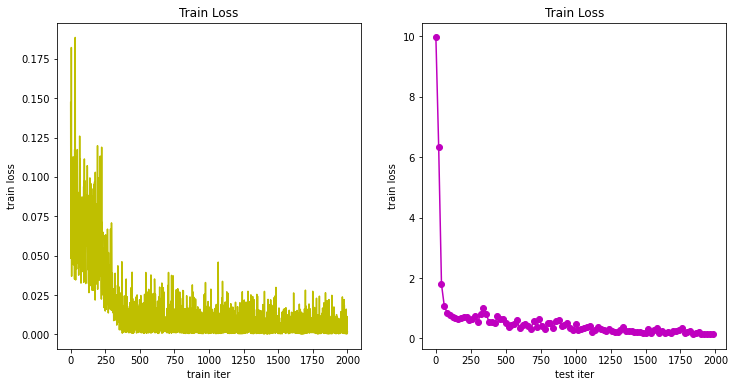

In [0]:
plot_train_test_losses(experiment_args, training_losses, test_losses)

As can be seen, the both the training and test losses decrease over the course of the training.

The curves suggest the Neural ODE training can converge to a local minimum but that the convergence process is quite noisy.

This might be because the dynamics are quite sensitive to updates in the parameters.

Perhaps the training can benefit from a decaying schedule for the gradient descent step sizes.

### Make GIF

In [0]:
!rm -rf pngs_for_gif
!mkdir pngs_for_gif
!ls -v pngs | cat -n | while read n f; do mv -n "pngs/$f" `printf "pngs_for_gif/%04d.png" $n`; done

In [0]:
!rm output.gif
!rm palette.png
!ffmpeg -i pngs_for_gif/%04d.png -vf palettegen palette.png
!ffmpeg -i pngs_for_gif/%04d.png -i palette.png -lavfi paletteuse output.gif

rm: cannot remove 'output.gif': No such file or directory
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libweb

## References

I've "borrowed" heavily from the original Neural ODEs paper, the torchdiffeq code, as well the Jax documentation.

* Jax
  * [Docs](https://jax.readthedocs.io/en/latest/index.html)
  * [Neural Network and Data Loading notebook](https://github.com/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb.)

* Neural ODEs
  * [Paper .pdf on arxiv](https://arxiv.org/pdf/1806.07366.pdf)
  * [torchdiffeq](https://github.com/rtqichen/torchdiffeq)